In [102]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [103]:
captions = readTextFile("./Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")

In [104]:
captions = captions.split("\n")[:-1]

In [105]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [106]:
img_Desc = {}

for x in captions:
    one,two = x.split("\t")
    img_name = one.split(".")[0]
    
    #if image name exists then append otherwise dont append.
    
    if img_Desc.get(img_name) is None:
        img_Desc[img_name] = []
    
    img_Desc[img_name].append(two)

In [107]:
img_Desc["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [108]:
import cv2

In [109]:
import matplotlib.pyplot as plt


In [110]:
IMG_PATH = "./Flickr_Data/Flickr_Data/Images/"

In [111]:
###DATACLEANING
import re

In [112]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    #sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [113]:
clean_text("A cat is sitting over the house # 64")

'a cat is sitting over the house'

In [114]:
for key,caption_list in img_Desc.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [115]:
img_Desc["1000268201_693b08cb0e"]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a girl going into a wooden building',
 'a little girl climbing into a wooden playhouse',
 'a little girl climbing the stairs to her playhouse',
 'a little girl in a pink dress going into a wooden cabin']

In [116]:
with open("img_desc.txt","w") as f:
    f.write(str(img_Desc))

In [117]:
import json

In [118]:
descriptions = None
with open("img_desc.txt","r") as f:
    descriptions=f.read()
    
json_string = descriptions.replace("'","\"")
descriptions = json.loads(json_string) 

In [119]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print("Vocab Size: %d"% len(vocab))

Vocab Size: 8441


In [120]:
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print("Total Words %d"%len(total_words))

Total Words 437466


In [121]:
import collections

In [122]:
counter = collections.Counter(total_words)
print(type(counter))

<class 'collections.Counter'>


In [123]:
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8441


In [124]:
# Sorting total_Words according to their count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

#Filter
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_cnt]

In [125]:
print(len(total_words))

1850


In [126]:
##Prepare Train/Test Data 

In [127]:
train_file_data = readTextFile("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [169]:
#print(train_file_data)
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [129]:
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [179]:
train_descriptions["2513260012_03d33305cf"]
#len(train_descriptions)

['startseq a black dog is running after a white dog in the snow endseq',
 'startseq black dog chasing brown dog through snow endseq',
 'startseq two dogs chase each other across the snowy ground endseq',
 'startseq two dogs play together in the snow endseq',
 'startseq two dogs running through a low lying body of water endseq']

In [131]:
import keras

In [132]:
import tensorflow

In [133]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

In [134]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7901766126072229612
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2204421324
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9541428026412371056
physical_device_desc: "device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [135]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [136]:
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add


In [137]:
from keras.models import load_model
from keras.models import Model

In [138]:
model_new = Model(model.input,model.layers[-2].output)

In [139]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    #Normalising
    img = preprocess_input(img)
    return img


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<function matplotlib.pyplot.show(*args, **kw)>

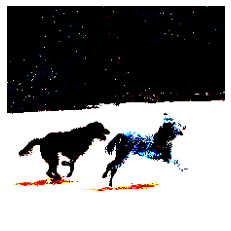

In [171]:
img= preprocess_img(IMG_PATH+"2513260012_03d33305cf.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show

In [141]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [142]:
encoding_train ={}

start_t=time()

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time Step %d"%ix)
end_t = time()
print("Total Time Taken:",end_t-start_t)

Encoding in Progress Time Step 0
Encoding in Progress Time Step 100
Encoding in Progress Time Step 200
Encoding in Progress Time Step 300
Encoding in Progress Time Step 400
Encoding in Progress Time Step 500
Encoding in Progress Time Step 600
Encoding in Progress Time Step 700
Encoding in Progress Time Step 800
Encoding in Progress Time Step 900
Encoding in Progress Time Step 1000
Encoding in Progress Time Step 1100
Encoding in Progress Time Step 1200
Encoding in Progress Time Step 1300
Encoding in Progress Time Step 1400
Encoding in Progress Time Step 1500
Encoding in Progress Time Step 1600
Encoding in Progress Time Step 1700
Encoding in Progress Time Step 1800
Encoding in Progress Time Step 1900
Encoding in Progress Time Step 2000
Encoding in Progress Time Step 2100
Encoding in Progress Time Step 2200
Encoding in Progress Time Step 2300
Encoding in Progress Time Step 2400
Encoding in Progress Time Step 2500
Encoding in Progress Time Step 2600
Encoding in Progress Time Step 2700
Enco

In [44]:
import pickle
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)
   

In [143]:
encoding_test ={}

start_t=time()

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding(TEST) in Progress Time Step %d"%ix)
end_t = time()
print("Total(TEST) Time Taken:",end_t-start_t)

Encoding(TEST) in Progress Time Step 0
Encoding(TEST) in Progress Time Step 100
Encoding(TEST) in Progress Time Step 200
Encoding(TEST) in Progress Time Step 300
Encoding(TEST) in Progress Time Step 400
Encoding(TEST) in Progress Time Step 500
Encoding(TEST) in Progress Time Step 600
Encoding(TEST) in Progress Time Step 700
Encoding(TEST) in Progress Time Step 800
Encoding(TEST) in Progress Time Step 900
Total(TEST) Time Taken: 24.00821352005005


In [95]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [89]:
with open('encoded_train_features.pkl', 'rb') as f:
    encoding_train = pickle.load(f)

In [96]:
with open('encoded_test_features.pkl', 'rb') as f:
    encoding_test = pickle.load(f)

In [87]:
len(total_words)

1850

In [144]:
word_to_idx={}
idx_to_word={}

for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word

In [145]:
idx_to_word[1851]='startseq'
word_to_idx['startseq']=1851

idx_to_word[1852]='endseq'
word_to_idx['endseq']=1852

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)


Vocab Size 1853


In [146]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))

In [147]:
max_len

38

In [180]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,y =[],[],[]
    n=0
    while True:
        for key,desc_list in train_descriptions.items():
            n+=1
            
            photo = encoding_train[key]
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield[[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n=0
                    
                

In [149]:
###Word Embedding

In [150]:
f = open("./glove.6B.50d.txt",encoding='utf8')

In [151]:
embedding_index={}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding= np.array(values[1:],dtype='float')
    embedding_index[word]= word_embedding
    
    
    

In [152]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [153]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix

In [154]:
embedding_matrix= get_embedding_matrix()
embedding_matrix.shape

(1853, 50)

In [155]:
embedding_matrix[1852]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [156]:
##Model architecture

In [157]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [158]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)


In [159]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

#Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [160]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 38)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 38, 50)       92650       input_6[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_5[0][0]                    
____________________________________________________________________________________________

In [161]:
#Pre Initialising the layer

In [162]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [163]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [164]:
#Training Model

In [165]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size


In [183]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')
        

In [184]:
train()

Epoch 1/1
2000/2000 [==============================] - 85s 43ms/step - loss: 3.1794
Epoch 1/1
2000/2000 [==============================] - 87s 44ms/step - loss: 2.9504
Epoch 1/1
2000/2000 [==============================] - 86s 43ms/step - loss: 2.8082
Epoch 1/1
2000/2000 [==============================] - 80s 40ms/step - loss: 2.7076
Epoch 1/1
2000/2000 [==============================] - 78s 39ms/step - loss: 2.6314
Epoch 1/1
2000/2000 [==============================] - 78s 39ms/step - loss: 2.5709
Epoch 1/1
2000/2000 [==============================] - 79s 39ms/step - loss: 2.5227
Epoch 1/1
2000/2000 [==============================] - 79s 39ms/step - loss: 2.4827
Epoch 1/1
2000/2000 [==============================] - 77s 38ms/step - loss: 2.4469
Epoch 1/1
2000/2000 [==============================] - 79s 39ms/step - loss: 2.4144
Epoch 1/1
2000/2000 [==============================] - 89s 45ms/step - loss: 2.3896
Epoch 1/1
2000/2000 [==============================] - 81s 40ms/step - loss:

In [177]:
len(encoding_train["2513260012_03d33305cf"])

2048

In [185]:
model = load_model('./model_weights/model_19.h5')

In [192]:
def predict_caption(photo):
    in_text ="startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred= model.predict([photo,sequence])
        ypred= ypred.argmax()
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        
        if word == 'endseq':
            break
    final_caption= in_text.split()[1:-1]
    final_caption= ' '.join(final_caption)
        
    return final_caption

a boy in a red shirt and jeans is standing in a grassy field


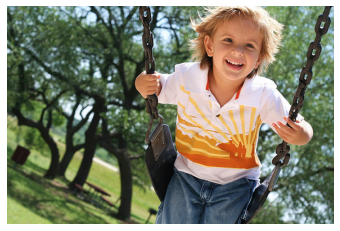

a man wearing sunglasses and a black shirt and sunglasses and a blue shirt smiles


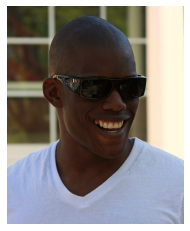

a black and white dog jumping over a hurdle


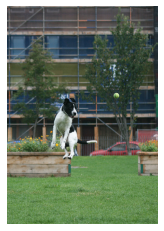

a man in a red shirt and blue shorts is jumping over a hurdle


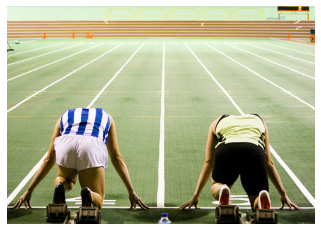

a woman in a red sweater and brown hair walks down a busy street


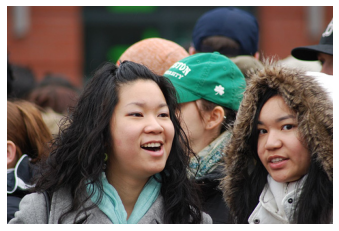

a man on a bike is riding on a dirt path


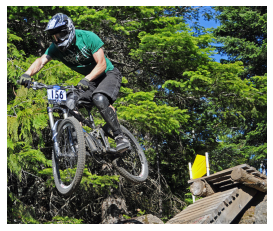

a dog running through the snow


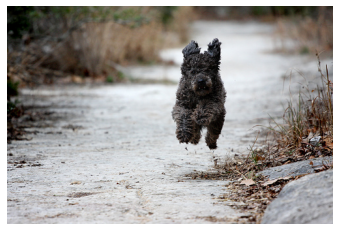

a black dog running through the green grass


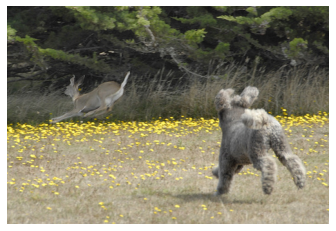

a girl in a red shirt is standing in a park


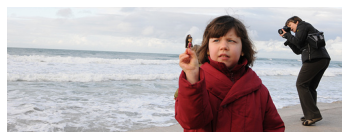

a boy in a blue shirt is jumping on a swing


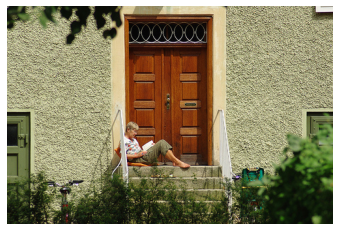

a girl in a blue shirt is splashing in a swimming pool


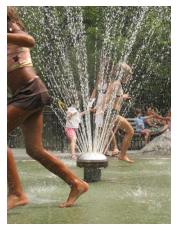

a boy in a blue shirt and jeans is jumping on a swing


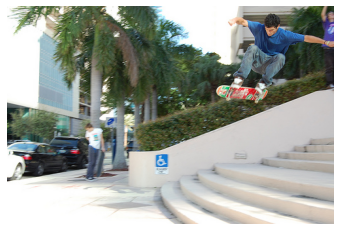

a man in a black shirt is standing on a beach with a fishing pole


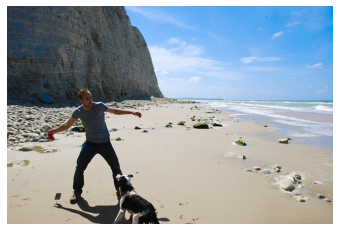

a man in a green shirt is standing in front of a colorful building


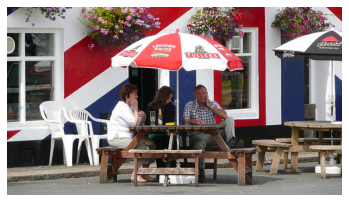

a group of people are sitting on a bench under a mountain


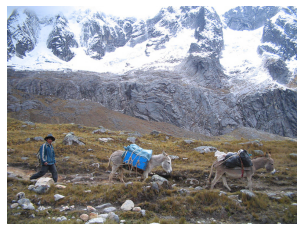

In [193]:
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("./Flickr_Data/Flickr_Data/Images/"+img_name+".jpg")
    caption = predict_caption(photo_2048)
    print(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

In [194]:
photoaman=encode_image("pic.jpg")

In [196]:
photo_20=photoaman.reshape((1,2048))

In [197]:
caption = predict_caption(photo_20)

In [198]:
print(caption)

a man in a blue shirt and blue shorts is hitting a ball
